In [17]:
### SETUP ###
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import PIL
import PIL.Image
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow_hub as hub


dirname = '/kaggle/input/celebrity-face-image-dataset/Celebrity Faces Dataset/'

class_count = 17
ds_size = 17*100 + 100

batch_size = 32
img_height = 224
img_width = 224

## Reference: https://www.tensorflow.org/tutorials/images/classification
## Use 80% of the images for training and 20% for validation.
## Below is 80% of Training
train_ds = tf.keras.utils.image_dataset_from_directory(
  dirname,
  validation_split=0.20,
  subset="training",
  seed=123,
  image_size=(img_height, img_width))

## Below is the 20% for Validation
test_ds = tf.keras.utils.image_dataset_from_directory(
  dirname,
  validation_split=0.20,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width))

## Creating test and validation datasets (10%-10%)
## Reference; https://stackoverflow.com/questions/48213766/split-a-dataset-created-by-tensorflow-dataset-api-in-to-train-and-test#:~:text=A%20robust%20way%20to%20split,by%20filtering%20by%20the%20bucket.
val_size = int(0.1 * ds_size)
test_size = int(0.1 * ds_size)

validation_ds = test_ds.take(val_size)
testing_ds = test_ds.skip(test_size)
print(f"testing_ds: {testing_ds}")
print(f"validation: {validation_ds}")

## Class Names
class_names = train_ds.class_names
print(test_ds.class_names)

## Do data augmentation to training and validation set only
## Reference: https://pyimagesearch.com/2021/06/28/data-augmentation-with-tf-data-and-tensorflow/



Found 1800 files belonging to 17 classes.
Using 1440 files for training.
Found 1800 files belonging to 17 classes.
Using 360 files for validation.
testing_ds: <SkipDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>
validation: <TakeDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>
['Angelina Jolie', 'Brad Pitt', 'Denzel Washington', 'Hugh Jackman', 'Jennifer Lawrence', 'Johnny Depp', 'Kate Winslet', 'Leonardo DiCaprio', 'Megan Fox', 'Natalie Portman', 'Nicole Kidman', 'Robert Downey Jr', 'Sandra Bullock', 'Scarlett Johansson', 'Tom Cruise', 'Tom Hanks', 'Will Smith']


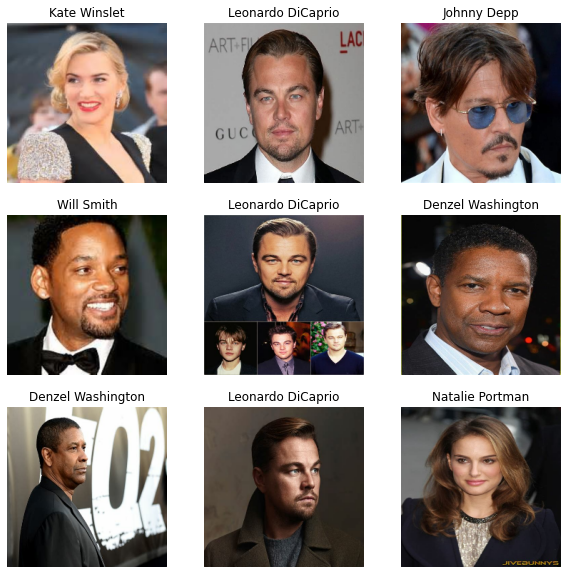

In [18]:
## Visualize the Data
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [19]:
# Batch size refers to the # of training examples utilized 
# in one iteration.
# I can call .numpy() on the image_batch and labels_batch tensors 
# to convert them to a numpy.ndarray.

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [21]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = validation_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [23]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [24]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


2022-11-19 03:40:38.245911: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-11-19 03:40:38.246201: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [25]:
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = inception_v3 #@param ["mobilenet_v2", "inception_v3"] {type:"raw"}

In [37]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

In [38]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 2048)


In [40]:
# Classificaiton Head
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_2 (Dense)              (None, 17)                34833     
Total params: 21,837,617
Trainable params: 34,833
Non-trainable params: 21,802,784
_________________________________________________________________


In [41]:
predictions = model(image_batch)

In [42]:
predictions.shape

TensorShape([32, 17])

In [43]:
import datetime
# Train the Model
# Train the model for 10 epochs with the Keras Model.fit method
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

2022-11-19 04:04:31.512671: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-11-19 04:04:31.513006: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-11-19 04:04:31.513130: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


In [44]:
NUM_EPOCHS = 10

history = model.fit(train_ds,
                    validation_data=validation_ds,
                    epochs=NUM_EPOCHS)

Epoch 1/10
45/45 [==============================] - 72s 2s/step - loss: 2.4166 - acc: 0.2035 - val_loss: 127.0400 - val_acc: 0.0500
Epoch 2/10
45/45 [==============================] - 68s 2s/step - loss: 1.6985 - acc: 0.4278 - val_loss: 152.3156 - val_acc: 0.0556
Epoch 3/10
45/45 [==============================] - 67s 1s/step - loss: 1.4079 - acc: 0.5396 - val_loss: 177.3182 - val_acc: 0.0500
Epoch 4/10
45/45 [==============================] - 67s 1s/step - loss: 1.2077 - acc: 0.6292 - val_loss: 199.8102 - val_acc: 0.0472
Epoch 5/10
45/45 [==============================] - 67s 2s/step - loss: 1.0590 - acc: 0.6889 - val_loss: 218.8784 - val_acc: 0.0472
Epoch 6/10
45/45 [==============================] - 67s 2s/step - loss: 0.9418 - acc: 0.7347 - val_loss: 233.9092 - val_acc: 0.0472
Epoch 7/10
45/45 [==============================] - 67s 1s/step - loss: 0.8448 - acc: 0.7694 - val_loss: 245.0961 - val_acc: 0.0472
Epoch 8/10
45/45 [==============================] - 67s 1s/step - loss: 0.76

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

KeyError: 'accuracy'

In [45]:
# Visualize Training Results
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

# Plot the predictions
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
# Data Augmentation
# Because our model is overfitting
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
# Dropout
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [ ]:
# Compile and Train the Model Again

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs = 15
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs
)

In [ ]:
# Visualize Training Results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()